In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import pandas as pd

df = pd.read_parquet("transactions.parquet")
df['year'] = df['Order_Date_FK'].astype(str).str[:4]
df['month'] = df['Order_Date_FK'].astype(str).str[4:6]
df['day'] = df['Order_Date_FK'].astype(str).str[6:]

In [2]:
from sklearn.preprocessing import TargetEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

cat_features = [
    # 'SaleDocumentNumber',
    # 'CustomerID',
    # 'ProductCode',
    'Shop',
    'BrandName',
    'ModelGroup',
    # 'Order_Date_FK',
    'ProductGroup',
    'day',
    'month',
    # 'year',
]
num_features = [
    "OriginalSaleAmountInclVAT",
    # "RevenueInclVAT",
    # "CostPriceExclVAT"
]

X, y = df[num_features + cat_features], df["Returned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69420, test_size=0.2)

rus = RandomUnderSampler(sampling_strategy=0.25, random_state=69420)
ros = RandomOverSampler(sampling_strategy=0.5, random_state=69420)

X_train, y_train = rus.fit_resample(X_train, y_train)
X_train, y_train = ros.fit_resample(X_train, y_train)

enc = TargetEncoder(smooth='auto').fit(X_train[cat_features], y_train)
feature_names = enc.get_feature_names_out()

X_train_enc = enc.transform(X=X_train[cat_features])
X_test_enc = enc.transform(X=X_test[cat_features])
X_train_enc = pd.DataFrame(X_train_enc, columns=feature_names)
X_test_enc = pd.DataFrame(X_test_enc, columns=feature_names)

X_train = pd.concat([X_train_enc, X_train[num_features].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_enc, X_test[num_features].reset_index(drop=True)], axis=1)

rf_classifier = RandomForestClassifier(
    class_weight = 'balanced',
    random_state = 69420,
    max_depth = 50,
    min_samples_split = 2,
    n_estimators = 100
)

In [3]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       random_state=69420)

In [4]:
f_imp = pd.DataFrame([rf_classifier.feature_names_in_, rf_classifier.feature_importances_]).transpose()
f_imp.columns = ['feature', 'importance']

f_imp.sort_values(by=['importance'], ascending=False)

,feature,importance
0,Shop,0.407006
4,day,0.21389
1,BrandName,0.162051
6,OriginalSaleAmountInclVAT,0.141935
2,ModelGroup,0.040198
5,month,0.020485
3,ProductGroup,0.014436


In [5]:
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred)

# print("FEATURES: ", rf_classifier.feature_names_in_, "\n")
print(report)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95    338351
           1       0.26      0.80      0.39     13627

    accuracy                           0.91    351978
   macro avg       0.63      0.85      0.67    351978
weighted avg       0.96      0.91      0.93    351978



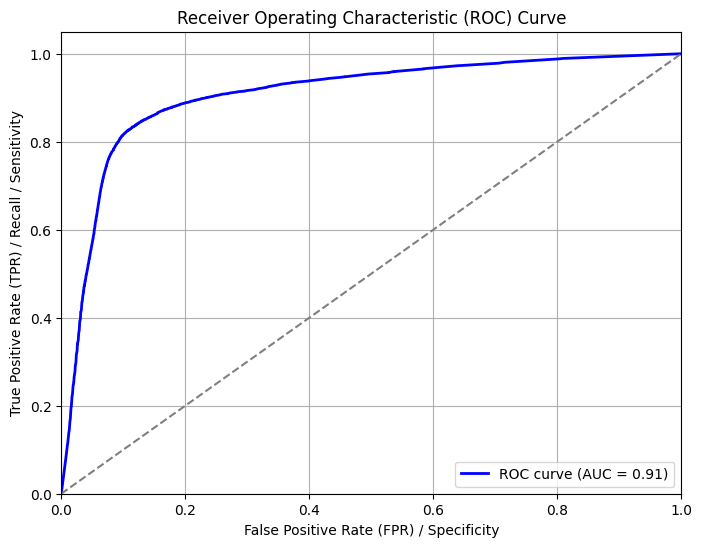

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

# ROC & AUC
y_pred_prob = rf_classifier.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR) / Specificity')
plt.ylabel('True Positive Rate (TPR) / Recall / Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [8]:
# Function that plots a Lift Curve using the real label values of a dataset and the probability predictions of a Machine Learning Algorithm/model
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# step: how big we want the steps in the percentiles to be
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

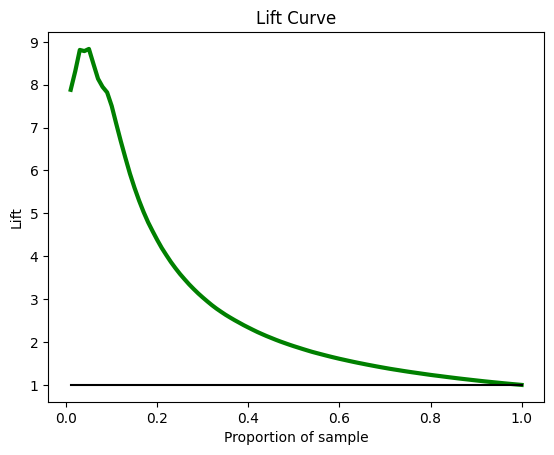

In [9]:
plot_lift_curve(y_test, y_pred_prob[:,1])

In [10]:
import joblib

# Save the model
artifacts = {
    "features": {
        "num_features": num_features,
        "cat_features": cat_features,
    },
    "enc": enc,
    "model": rf_classifier,
}
joblib.dump(artifacts, "artifacts_rf_better.joblib")

['artifacts_rf_better.joblib']